## Classes for callback implementors

In [ ]:
from fastai.gen_doc.nbdoc import *
from fastai.callback import * 
from fastai.basics import *

fastai provides a powerful *callback* system, which is documented on the [`callbacks`](/callbacks.html#callbacks) page; look on that page if you're just looking for how to use existing callbacks. If you want to create your own, you'll need to use the classes discussed below.

A key motivation for the callback system is that additional functionality can be entirely implemented in a single callback, so that it's easily read. By using this trick, we will have different methods categorized in different callbacks where we will find clearly stated all the interventions the method makes in training. For instance in the [`LRFinder`](/callbacks.lr_finder.html#LRFinder) callback, on top of running the fit function with exponentially growing LRs, it needs to handle some preparation and clean-up, and all this code can be in the same callback so we know exactly what it is doing and where to look if we need to change something.

In addition, it allows our [`fit`](/basic_train.html#fit) function to be very clean and simple, yet still easily extended. So far in implementing a number of recent papers, we haven't yet come across any situation where we had to modify our training loop source code - we've been able to use callbacks every time.

In [ ]:
show_doc(Callback)

<h2 id="Callback" class="doc_header"><code>class</code> <code>Callback</code><a href="https://github.com/fastai/fastai/blob/master/fastai/callback.py#L159" class="source_link" style="float:right">[source]</a><a class="source_link" data-toggle="collapse" data-target="#Callback-pytest" style="float:right; padding-right:10px">[test]</a></h2>

> <code>Callback</code>()

<div class="collapse" id="Callback-pytest"><div class="card card-body pytest_card"><a type="button" data-toggle="collapse" data-target="#Callback-pytest" class="close" aria-label="Close"><span aria-hidden="true">&times;</span></a><p>Tests found for <code>Callback</code>:</p><ul><li><code>pytest -sv tests/test_callback.py::test_callbacks_fit</code> <a href="https://github.com/fastai/fastai/blob/master/tests/test_callback.py#L64" class="source_link" style="float:right">[source]</a></li><li><code>pytest -sv tests/test_callback.py::test_callbacks_learner</code> <a href="https://github.com/fastai/fastai/blob/master/tests/test_callback.py#L33" class="source_link" style="float:right">[source]</a></li></ul><p>To run tests please refer to this <a href="/dev/test.html#quick-guide">guide</a>.</p></div></div>

Base class for callbacks that want to record values, dynamically change learner params, etc.  

To create a new type of callback, you'll need to inherit from this class, and implement one or more methods as required for your purposes. Perhaps the easiest way to get started is to look at the source code for some of the pre-defined fastai callbacks. You might be surprised at how simple they are! For instance, here is the **entire** source code for [`GradientClipping`](/train.html#GradientClipping):

```python
@dataclass
class GradientClipping(LearnerCallback):
    clip:float
    def on_backward_end(self, **kwargs):
        if self.clip:
            nn.utils.clip_grad_norm_(self.learn.model.parameters(), self.clip)
```

You generally want your custom callback constructor to take a [`Learner`](/basic_train.html#Learner) parameter, e.g.:

```python
@dataclass
class MyCallback(Callback):
    learn:Learner
```

Note that this allows the callback user to just pass your callback name to `callback_fns` when constructing their [`Learner`](/basic_train.html#Learner), since that always passes `self` when constructing callbacks from `callback_fns`. In addition, by passing the learner, this callback will have access to everything: e.g all the inputs/outputs as they are calculated, the losses, and also the data loaders, the optimizer, etc. At any time:
- Changing self.learn.data.train_dl or self.data.valid_dl will change them inside the fit function (we just need to pass the [`DataBunch`](/basic_data.html#DataBunch) object to the fit function and not data.train_dl/data.valid_dl)
- Changing self.learn.opt.opt (We have an [`OptimWrapper`](/callback.html#OptimWrapper) on top of the actual optimizer) will change it inside the fit function.
- Changing self.learn.data or self.learn.opt directly WILL NOT change the data or the optimizer inside the fit function.

In any of the callbacks you can unpack in the kwargs:
- `n_epochs`, contains the number of epochs the training will take in total
- `epoch`, contains the number of the current
- `iteration`, contains the number of iterations done since the beginning of training
- `num_batch`, contains the number of the batch we're at in the dataloader
- `last_input`, contains the last input that got through the model (eventually updated by a callback)
- `last_target`, contains the last target that got through the model (eventually updated by a callback)
- `last_output`, contains the last output spitted by the model (eventually updated by a callback)
- `last_loss`, contains the last loss computed (eventually updated by a callback)
- `smooth_loss`, contains the smoothed version of the loss
- `last_metrics`, contains the last validation loss and metrics computed
- `pbar`, the progress bar
- [`train`](/train.html#train), flag to know if we're in training mode or not
- `stop_training`, that will stop the training at the end of the current epoch if True
- `stop_epoch`, that will break the current epoch loop
- `skip_step`, that will skip the next optimizer step
- `skip_zero`, that will skip the next zero grad

When returning a dictionary with those key names, the state of the [`CallbackHandler`](/callback.html#CallbackHandler) will be updated with any of those changes, so in any [`Callback`](/callback.html#Callback), you can change those values.

### Methods your subclass can implement

All of these methods are optional; your subclass can handle as many or as few as you require.

In [ ]:
show_doc(Callback.on_train_begin)

<h4 id="Callback.on_train_begin" class="doc_header"><code>on_train_begin</code><a href="https://github.com/fastai/fastai/blob/master/fastai/callback.py#L162" class="source_link" style="float:right">[source]</a><a class="source_link" data-toggle="collapse" data-target="#Callback-on_train_begin-pytest" style="float:right; padding-right:10px">[test]</a></h4>

> <code>on_train_begin</code>(**\*\*`kwargs`**:`Any`)

<div class="collapse" id="Callback-on_train_begin-pytest"><div class="card card-body pytest_card"><a type="button" data-toggle="collapse" data-target="#Callback-on_train_begin-pytest" class="close" aria-label="Close"><span aria-hidden="true">&times;</span></a><p>No tests found for <code>on_train_begin</code>. To contribute a test please refer to <a href="/dev/test.html">this guide</a> and <a href="https://forums.fast.ai/t/improving-expanding-functional-tests/32929">this discussion</a>.</p></div></div>

To initialize constants in the callback.  

Here we can initiliaze anything we need. 
The optimizer has now been initialized. We can change any hyper-parameters by typing, for instance:

```
self.opt.lr = new_lr
self.opt.mom = new_mom
self.opt.wd = new_wd
self.opt.beta = new_beta
```

In [ ]:
show_doc(Callback.on_epoch_begin)

<h4 id="Callback.on_epoch_begin" class="doc_header"><code>on_epoch_begin</code><a href="https://github.com/fastai/fastai/blob/master/fastai/callback.py#L165" class="source_link" style="float:right">[source]</a><a class="source_link" data-toggle="collapse" data-target="#Callback-on_epoch_begin-pytest" style="float:right; padding-right:10px">[test]</a></h4>

> <code>on_epoch_begin</code>(**\*\*`kwargs`**:`Any`)

<div class="collapse" id="Callback-on_epoch_begin-pytest"><div class="card card-body pytest_card"><a type="button" data-toggle="collapse" data-target="#Callback-on_epoch_begin-pytest" class="close" aria-label="Close"><span aria-hidden="true">&times;</span></a><p>No tests found for <code>on_epoch_begin</code>. To contribute a test please refer to <a href="/dev/test.html">this guide</a> and <a href="https://forums.fast.ai/t/improving-expanding-functional-tests/32929">this discussion</a>.</p></div></div>

At the beginning of each epoch.  

This is not technically required since we have `on_train_begin` for epoch 0 and `on_epoch_end` for all the other epochs,
yet it makes writing code that needs to be done at the beginning of every epoch easy and more readable.

In [ ]:
show_doc(Callback.on_batch_begin)

<h4 id="Callback.on_batch_begin" class="doc_header"><code>on_batch_begin</code><a href="https://github.com/fastai/fastai/blob/master/fastai/callback.py#L168" class="source_link" style="float:right">[source]</a><a class="source_link" data-toggle="collapse" data-target="#Callback-on_batch_begin-pytest" style="float:right; padding-right:10px">[test]</a></h4>

> <code>on_batch_begin</code>(**\*\*`kwargs`**:`Any`)

<div class="collapse" id="Callback-on_batch_begin-pytest"><div class="card card-body pytest_card"><a type="button" data-toggle="collapse" data-target="#Callback-on_batch_begin-pytest" class="close" aria-label="Close"><span aria-hidden="true">&times;</span></a><p>No tests found for <code>on_batch_begin</code>. To contribute a test please refer to <a href="/dev/test.html">this guide</a> and <a href="https://forums.fast.ai/t/improving-expanding-functional-tests/32929">this discussion</a>.</p></div></div>

Set HP before the output and loss are computed.  

Here is the perfect place to prepare everything before the model is called.
Example: change the values of the hyperparameters (if we don't do it on_batch_end instead)

At the end of that event `xb`,`yb` will be set to `last_input`, `last_target` of the state of the [`CallbackHandler`](/callback.html#CallbackHandler).

In [ ]:
show_doc(Callback.on_loss_begin)

<h4 id="Callback.on_loss_begin" class="doc_header"><code>on_loss_begin</code><a href="https://github.com/fastai/fastai/blob/master/fastai/callback.py#L171" class="source_link" style="float:right">[source]</a><a class="source_link" data-toggle="collapse" data-target="#Callback-on_loss_begin-pytest" style="float:right; padding-right:10px">[test]</a></h4>

> <code>on_loss_begin</code>(**\*\*`kwargs`**:`Any`)

<div class="collapse" id="Callback-on_loss_begin-pytest"><div class="card card-body pytest_card"><a type="button" data-toggle="collapse" data-target="#Callback-on_loss_begin-pytest" class="close" aria-label="Close"><span aria-hidden="true">&times;</span></a><p>No tests found for <code>on_loss_begin</code>. To contribute a test please refer to <a href="/dev/test.html">this guide</a> and <a href="https://forums.fast.ai/t/improving-expanding-functional-tests/32929">this discussion</a>.</p></div></div>

Called after forward pass but before loss has been computed.  

Here is the place to run some code that needs to be executed after the output has been computed but before the
loss computation.
Example: putting the output back in FP32 when training in mixed precision.

At the end of that event the output will be set to `last_output` of the state of the [`CallbackHandler`](/callback.html#CallbackHandler).

In [ ]:
show_doc(Callback.on_backward_begin)

<h4 id="Callback.on_backward_begin" class="doc_header"><code>on_backward_begin</code><a href="https://github.com/fastai/fastai/blob/master/fastai/callback.py#L174" class="source_link" style="float:right">[source]</a><a class="source_link" data-toggle="collapse" data-target="#Callback-on_backward_begin-pytest" style="float:right; padding-right:10px">[test]</a></h4>

> <code>on_backward_begin</code>(**\*\*`kwargs`**:`Any`)

<div class="collapse" id="Callback-on_backward_begin-pytest"><div class="card card-body pytest_card"><a type="button" data-toggle="collapse" data-target="#Callback-on_backward_begin-pytest" class="close" aria-label="Close"><span aria-hidden="true">&times;</span></a><p>No tests found for <code>on_backward_begin</code>. To contribute a test please refer to <a href="/dev/test.html">this guide</a> and <a href="https://forums.fast.ai/t/improving-expanding-functional-tests/32929">this discussion</a>.</p></div></div>

Called after the forward pass and the loss has been computed, but before backprop.  

Here is the place to run some code that needs to be executed after the loss has been computed but before the gradient computation.
Example: `reg_fn` in RNNs.

At the end of that event the output will be set to `last_loss` of the state of the [`CallbackHandler`](/callback.html#CallbackHandler).

In [ ]:
show_doc(Callback.on_backward_end)

<h4 id="Callback.on_backward_end" class="doc_header"><code>on_backward_end</code><a href="https://github.com/fastai/fastai/blob/master/fastai/callback.py#L177" class="source_link" style="float:right">[source]</a><a class="source_link" data-toggle="collapse" data-target="#Callback-on_backward_end-pytest" style="float:right; padding-right:10px">[test]</a></h4>

> <code>on_backward_end</code>(**\*\*`kwargs`**:`Any`)

<div class="collapse" id="Callback-on_backward_end-pytest"><div class="card card-body pytest_card"><a type="button" data-toggle="collapse" data-target="#Callback-on_backward_end-pytest" class="close" aria-label="Close"><span aria-hidden="true">&times;</span></a><p>No tests found for <code>on_backward_end</code>. To contribute a test please refer to <a href="/dev/test.html">this guide</a> and <a href="https://forums.fast.ai/t/improving-expanding-functional-tests/32929">this discussion</a>.</p></div></div>

Called after backprop but before optimizer step. Useful for true weight decay in AdamW.  

Here is the place to run some code that needs to be executed after the gradients have been computed but
before the optimizer is called.

If `skip_step` is `True` at the end of this event, the optimizer step is skipped.

In [ ]:
show_doc(Callback.on_step_end)

<h4 id="Callback.on_step_end" class="doc_header"><code>on_step_end</code><a href="https://github.com/fastai/fastai/blob/master/fastai/callback.py#L180" class="source_link" style="float:right">[source]</a><a class="source_link" data-toggle="collapse" data-target="#Callback-on_step_end-pytest" style="float:right; padding-right:10px">[test]</a></h4>

> <code>on_step_end</code>(**\*\*`kwargs`**:`Any`)

<div class="collapse" id="Callback-on_step_end-pytest"><div class="card card-body pytest_card"><a type="button" data-toggle="collapse" data-target="#Callback-on_step_end-pytest" class="close" aria-label="Close"><span aria-hidden="true">&times;</span></a><p>No tests found for <code>on_step_end</code>. To contribute a test please refer to <a href="/dev/test.html">this guide</a> and <a href="https://forums.fast.ai/t/improving-expanding-functional-tests/32929">this discussion</a>.</p></div></div>

Called after the step of the optimizer but before the gradients are zeroed.  

Here is the place to run some code that needs to be executed after the optimizer step but before the gradients
are zeroed.

If `skip_zero` is `True` at the end of this event, the gradients are not zeroed.

In [ ]:
show_doc(Callback.on_batch_end)

<h4 id="Callback.on_batch_end" class="doc_header"><code>on_batch_end</code><a href="https://github.com/fastai/fastai/blob/master/fastai/callback.py#L183" class="source_link" style="float:right">[source]</a><a class="source_link" data-toggle="collapse" data-target="#Callback-on_batch_end-pytest" style="float:right; padding-right:10px">[test]</a></h4>

> <code>on_batch_end</code>(**\*\*`kwargs`**:`Any`)

<div class="collapse" id="Callback-on_batch_end-pytest"><div class="card card-body pytest_card"><a type="button" data-toggle="collapse" data-target="#Callback-on_batch_end-pytest" class="close" aria-label="Close"><span aria-hidden="true">&times;</span></a><p>No tests found for <code>on_batch_end</code>. To contribute a test please refer to <a href="/dev/test.html">this guide</a> and <a href="https://forums.fast.ai/t/improving-expanding-functional-tests/32929">this discussion</a>.</p></div></div>

Called at the end of the batch.  

Here is the place to run some code that needs to be executed after a batch is fully done.
Example: change the values of the hyperparameters (if we don't do it on_batch_begin instead)

If `end_epoch` is `True` at the end of this event, the current epoch is interrupted (example: lr_finder stops the training when the loss explodes).

In [ ]:
show_doc(Callback.on_epoch_end)

<h4 id="Callback.on_epoch_end" class="doc_header"><code>on_epoch_end</code><a href="https://github.com/fastai/fastai/blob/master/fastai/callback.py#L186" class="source_link" style="float:right">[source]</a><a class="source_link" data-toggle="collapse" data-target="#Callback-on_epoch_end-pytest" style="float:right; padding-right:10px">[test]</a></h4>

> <code>on_epoch_end</code>(**\*\*`kwargs`**:`Any`)

<div class="collapse" id="Callback-on_epoch_end-pytest"><div class="card card-body pytest_card"><a type="button" data-toggle="collapse" data-target="#Callback-on_epoch_end-pytest" class="close" aria-label="Close"><span aria-hidden="true">&times;</span></a><p>No tests found for <code>on_epoch_end</code>. To contribute a test please refer to <a href="/dev/test.html">this guide</a> and <a href="https://forums.fast.ai/t/improving-expanding-functional-tests/32929">this discussion</a>.</p></div></div>

Called at the end of an epoch.  

Here is the place to run some code that needs to be executed at the end of an epoch.
Example: Save the model if we have a new best validation loss/metric.

If `end_training` is `True` at the end of this event, the training stops (example: early stopping).

In [ ]:
show_doc(Callback.on_train_end)

<h4 id="Callback.on_train_end" class="doc_header"><code>on_train_end</code><a href="https://github.com/fastai/fastai/blob/master/fastai/callback.py#L189" class="source_link" style="float:right">[source]</a><a class="source_link" data-toggle="collapse" data-target="#Callback-on_train_end-pytest" style="float:right; padding-right:10px">[test]</a></h4>

> <code>on_train_end</code>(**\*\*`kwargs`**:`Any`)

<div class="collapse" id="Callback-on_train_end-pytest"><div class="card card-body pytest_card"><a type="button" data-toggle="collapse" data-target="#Callback-on_train_end-pytest" class="close" aria-label="Close"><span aria-hidden="true">&times;</span></a><p>No tests found for <code>on_train_end</code>. To contribute a test please refer to <a href="/dev/test.html">this guide</a> and <a href="https://forums.fast.ai/t/improving-expanding-functional-tests/32929">this discussion</a>.</p></div></div>

Useful for cleaning up things and saving files/models.  

Here is the place to tidy everything. It's always executed even if there was an error during the training loop,
and has an extra kwarg named exception to check if there was an exception or not.
Examples: save log_files, load best model found during training

In [ ]:
show_doc(Callback.get_state)

<h4 id="Callback.get_state" class="doc_header"><code>get_state</code><a href="https://github.com/fastai/fastai/blob/master/fastai/callback.py#L196" class="source_link" style="float:right">[source]</a><a class="source_link" data-toggle="collapse" data-target="#Callback-get_state-pytest" style="float:right; padding-right:10px">[test]</a></h4>

> <code>get_state</code>(**`minimal`**:`bool`=***`True`***)

<div class="collapse" id="Callback-get_state-pytest"><div class="card card-body pytest_card"><a type="button" data-toggle="collapse" data-target="#Callback-get_state-pytest" class="close" aria-label="Close"><span aria-hidden="true">&times;</span></a><p>No tests found for <code>get_state</code>. To contribute a test please refer to <a href="/dev/test.html">this guide</a> and <a href="https://forums.fast.ai/t/improving-expanding-functional-tests/32929">this discussion</a>.</p></div></div>

Return the inner state of the [`Callback`](/callback.html#Callback), `minimal` or not.  

This is used internally when trying to export a [`Learner`](/basic_train.html#Learner). You won't need to subclass this function but you can add attribute names to the lists `exclude` or `not_min`of the [`Callback`](/callback.html#Callback) you are designing. Attributes in `exclude` are never saved, attributes in `not_min` only if `minimal=False`.

## Annealing functions

The following functions provide different annealing schedules. You probably won't need to call them directly, but would instead use them as part of a callback. Here's what each one looks like:

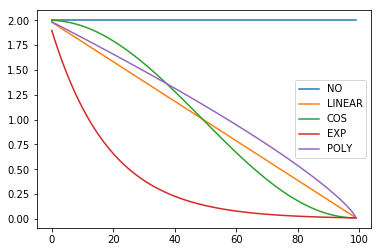

In [ ]:
annealings = "NO LINEAR COS EXP POLY".split()
fns = [annealing_no, annealing_linear, annealing_cos, annealing_exp, annealing_poly(0.8)]
for fn, t in zip(fns, annealings):
    plt.plot(np.arange(0, 100), [fn(2, 1e-2, o)
        for o in np.linspace(0.01,1,100)], label=t)
plt.legend();

In [ ]:
show_doc(annealing_cos)

<h4 id="annealing_cos" class="doc_header"><code>annealing_cos</code><a href="https://github.com/fastai/fastai/blob/master/fastai/callback.py#L364" class="source_link" style="float:right">[source]</a><a class="source_link" data-toggle="collapse" data-target="#annealing_cos-pytest" style="float:right; padding-right:10px">[test]</a></h4>

> <code>annealing_cos</code>(**`start`**:`Number`, **`end`**:`Number`, **`pct`**:`float`) → `Number`

<div class="collapse" id="annealing_cos-pytest"><div class="card card-body pytest_card"><a type="button" data-toggle="collapse" data-target="#annealing_cos-pytest" class="close" aria-label="Close"><span aria-hidden="true">&times;</span></a><p>No tests found for <code>annealing_cos</code>. To contribute a test please refer to <a href="/dev/test.html">this guide</a> and <a href="https://forums.fast.ai/t/improving-expanding-functional-tests/32929">this discussion</a>.</p></div></div>

Cosine anneal from `start` to `end` as pct goes from 0.0 to 1.0.  

In [ ]:
show_doc(annealing_exp)

<h4 id="annealing_exp" class="doc_header"><code>annealing_exp</code><a href="https://github.com/fastai/fastai/blob/master/fastai/callback.py#L361" class="source_link" style="float:right">[source]</a><a class="source_link" data-toggle="collapse" data-target="#annealing_exp-pytest" style="float:right; padding-right:10px">[test]</a></h4>

> <code>annealing_exp</code>(**`start`**:`Number`, **`end`**:`Number`, **`pct`**:`float`) → `Number`

<div class="collapse" id="annealing_exp-pytest"><div class="card card-body pytest_card"><a type="button" data-toggle="collapse" data-target="#annealing_exp-pytest" class="close" aria-label="Close"><span aria-hidden="true">&times;</span></a><p>No tests found for <code>annealing_exp</code>. To contribute a test please refer to <a href="/dev/test.html">this guide</a> and <a href="https://forums.fast.ai/t/improving-expanding-functional-tests/32929">this discussion</a>.</p></div></div>

Exponentially anneal from `start` to `end` as pct goes from 0.0 to 1.0.  

In [ ]:
show_doc(annealing_linear)

<h4 id="annealing_linear" class="doc_header"><code>annealing_linear</code><a href="https://github.com/fastai/fastai/blob/master/fastai/callback.py#L358" class="source_link" style="float:right">[source]</a><a class="source_link" data-toggle="collapse" data-target="#annealing_linear-pytest" style="float:right; padding-right:10px">[test]</a></h4>

> <code>annealing_linear</code>(**`start`**:`Number`, **`end`**:`Number`, **`pct`**:`float`) → `Number`

<div class="collapse" id="annealing_linear-pytest"><div class="card card-body pytest_card"><a type="button" data-toggle="collapse" data-target="#annealing_linear-pytest" class="close" aria-label="Close"><span aria-hidden="true">&times;</span></a><p>No tests found for <code>annealing_linear</code>. To contribute a test please refer to <a href="/dev/test.html">this guide</a> and <a href="https://forums.fast.ai/t/improving-expanding-functional-tests/32929">this discussion</a>.</p></div></div>

Linearly anneal from `start` to `end` as pct goes from 0.0 to 1.0.  

In [ ]:
show_doc(annealing_no)

<h4 id="annealing_no" class="doc_header"><code>annealing_no</code><a href="https://github.com/fastai/fastai/blob/master/fastai/callback.py#L355" class="source_link" style="float:right">[source]</a><a class="source_link" data-toggle="collapse" data-target="#annealing_no-pytest" style="float:right; padding-right:10px">[test]</a></h4>

> <code>annealing_no</code>(**`start`**:`Number`, **`end`**:`Number`, **`pct`**:`float`) → `Number`

<div class="collapse" id="annealing_no-pytest"><div class="card card-body pytest_card"><a type="button" data-toggle="collapse" data-target="#annealing_no-pytest" class="close" aria-label="Close"><span aria-hidden="true">&times;</span></a><p>No tests found for <code>annealing_no</code>. To contribute a test please refer to <a href="/dev/test.html">this guide</a> and <a href="https://forums.fast.ai/t/improving-expanding-functional-tests/32929">this discussion</a>.</p></div></div>

No annealing, always return `start`.  

In [ ]:
show_doc(annealing_poly)

<h4 id="annealing_poly" class="doc_header"><code>annealing_poly</code><a href="https://github.com/fastai/fastai/blob/master/fastai/callback.py#L372" class="source_link" style="float:right">[source]</a><a class="source_link" data-toggle="collapse" data-target="#annealing_poly-pytest" style="float:right; padding-right:10px">[test]</a></h4>

> <code>annealing_poly</code>(**`degree`**:`Number`) → `Number`

<div class="collapse" id="annealing_poly-pytest"><div class="card card-body pytest_card"><a type="button" data-toggle="collapse" data-target="#annealing_poly-pytest" class="close" aria-label="Close"><span aria-hidden="true">&times;</span></a><p>No tests found for <code>annealing_poly</code>. To contribute a test please refer to <a href="/dev/test.html">this guide</a> and <a href="https://forums.fast.ai/t/improving-expanding-functional-tests/32929">this discussion</a>.</p></div></div>

Anneal polynomically from `start` to `end` as pct goes from 0.0 to 1.0.  

In [ ]:
show_doc(CallbackHandler)

<h2 id="CallbackHandler" class="doc_header"><code>class</code> <code>CallbackHandler</code><a href="https://github.com/fastai/fastai/blob/master/fastai/callback.py#L224" class="source_link" style="float:right">[source]</a><a class="source_link" data-toggle="collapse" data-target="#CallbackHandler-pytest" style="float:right; padding-right:10px">[test]</a></h2>

> <code>CallbackHandler</code>(**`callbacks`**:`Collection`\[[`Callback`](/callback.html#Callback)\]=***`None`***, **`metrics`**:`Collection`\[[`Callback`](/callback.html#Callback)\]=***`None`***, **`beta`**:`float`=***`0.98`***)

<div class="collapse" id="CallbackHandler-pytest"><div class="card card-body pytest_card"><a type="button" data-toggle="collapse" data-target="#CallbackHandler-pytest" class="close" aria-label="Close"><span aria-hidden="true">&times;</span></a><p>No tests found for <code>CallbackHandler</code>. To contribute a test please refer to <a href="/dev/test.html">this guide</a> and <a href="https://forums.fast.ai/t/improving-expanding-functional-tests/32929">this discussion</a>.</p></div></div>

Manage all of the registered `callbacks` and `metrics`, smoothing loss by momentum `beta`.  

You probably won't need to use this class yourself. It's used by fastai to combine all the callbacks together and call any relevant callback functions for each training stage. The methods below simply call the equivalent method in each callback function in [`self.callbacks`](/callbacks.html#callbacks). 

In [ ]:
show_doc(CallbackHandler.on_backward_begin)

<h4 id="CallbackHandler.on_backward_begin" class="doc_header"><code>on_backward_begin</code><a href="https://github.com/fastai/fastai/blob/master/fastai/callback.py#L288" class="source_link" style="float:right">[source]</a><a class="source_link" data-toggle="collapse" data-target="#CallbackHandler-on_backward_begin-pytest" style="float:right; padding-right:10px">[test]</a></h4>

> <code>on_backward_begin</code>(**`loss`**:`Tensor`) → `Tuple`\[`Any`, `Any`\]

<div class="collapse" id="CallbackHandler-on_backward_begin-pytest"><div class="card card-body pytest_card"><a type="button" data-toggle="collapse" data-target="#CallbackHandler-on_backward_begin-pytest" class="close" aria-label="Close"><span aria-hidden="true">&times;</span></a><p>No tests found for <code>on_backward_begin</code>. To contribute a test please refer to <a href="/dev/test.html">this guide</a> and <a href="https://forums.fast.ai/t/improving-expanding-functional-tests/32929">this discussion</a>.</p></div></div>

Handle gradient calculation on `loss`.  

In [ ]:
show_doc(CallbackHandler.on_backward_end)

<h4 id="CallbackHandler.on_backward_end" class="doc_header"><code>on_backward_end</code><a href="https://github.com/fastai/fastai/blob/master/fastai/callback.py#L295" class="source_link" style="float:right">[source]</a><a class="source_link" data-toggle="collapse" data-target="#CallbackHandler-on_backward_end-pytest" style="float:right; padding-right:10px">[test]</a></h4>

> <code>on_backward_end</code>() → `Any`

<div class="collapse" id="CallbackHandler-on_backward_end-pytest"><div class="card card-body pytest_card"><a type="button" data-toggle="collapse" data-target="#CallbackHandler-on_backward_end-pytest" class="close" aria-label="Close"><span aria-hidden="true">&times;</span></a><p>No tests found for <code>on_backward_end</code>. To contribute a test please refer to <a href="/dev/test.html">this guide</a> and <a href="https://forums.fast.ai/t/improving-expanding-functional-tests/32929">this discussion</a>.</p></div></div>

Handle end of gradient calculation.  

In [ ]:
show_doc(CallbackHandler.on_batch_begin)

<h4 id="CallbackHandler.on_batch_begin" class="doc_header"><code>on_batch_begin</code><a href="https://github.com/fastai/fastai/blob/master/fastai/callback.py#L275" class="source_link" style="float:right">[source]</a><a class="source_link" data-toggle="collapse" data-target="#CallbackHandler-on_batch_begin-pytest" style="float:right; padding-right:10px">[test]</a></h4>

> <code>on_batch_begin</code>(**`xb`**:`Tensor`, **`yb`**:`Tensor`, **`train`**:`bool`=***`True`***) → `Tuple`\[`Any`, `Any`\]

<div class="collapse" id="CallbackHandler-on_batch_begin-pytest"><div class="card card-body pytest_card"><a type="button" data-toggle="collapse" data-target="#CallbackHandler-on_batch_begin-pytest" class="close" aria-label="Close"><span aria-hidden="true">&times;</span></a><p>No tests found for <code>on_batch_begin</code>. To contribute a test please refer to <a href="/dev/test.html">this guide</a> and <a href="https://forums.fast.ai/t/improving-expanding-functional-tests/32929">this discussion</a>.</p></div></div>

Handle new batch `xb`,`yb` in `train` or validation.  

In [ ]:
show_doc(CallbackHandler.on_batch_end)

<h4 id="CallbackHandler.on_batch_end" class="doc_header"><code>on_batch_end</code><a href="https://github.com/fastai/fastai/blob/master/fastai/callback.py#L305" class="source_link" style="float:right">[source]</a><a class="source_link" data-toggle="collapse" data-target="#CallbackHandler-on_batch_end-pytest" style="float:right; padding-right:10px">[test]</a></h4>

> <code>on_batch_end</code>(**`loss`**:`Tensor`) → `Any`

<div class="collapse" id="CallbackHandler-on_batch_end-pytest"><div class="card card-body pytest_card"><a type="button" data-toggle="collapse" data-target="#CallbackHandler-on_batch_end-pytest" class="close" aria-label="Close"><span aria-hidden="true">&times;</span></a><p>No tests found for <code>on_batch_end</code>. To contribute a test please refer to <a href="/dev/test.html">this guide</a> and <a href="https://forums.fast.ai/t/improving-expanding-functional-tests/32929">this discussion</a>.</p></div></div>

Handle end of processing one batch with `loss`.  

In [ ]:
show_doc(CallbackHandler.on_epoch_begin)

<h4 id="CallbackHandler.on_epoch_begin" class="doc_header"><code>on_epoch_begin</code><a href="https://github.com/fastai/fastai/blob/master/fastai/callback.py#L270" class="source_link" style="float:right">[source]</a><a class="source_link" data-toggle="collapse" data-target="#CallbackHandler-on_epoch_begin-pytest" style="float:right; padding-right:10px">[test]</a></h4>

> <code>on_epoch_begin</code>()

<div class="collapse" id="CallbackHandler-on_epoch_begin-pytest"><div class="card card-body pytest_card"><a type="button" data-toggle="collapse" data-target="#CallbackHandler-on_epoch_begin-pytest" class="close" aria-label="Close"><span aria-hidden="true">&times;</span></a><p>No tests found for <code>on_epoch_begin</code>. To contribute a test please refer to <a href="/dev/test.html">this guide</a> and <a href="https://forums.fast.ai/t/improving-expanding-functional-tests/32929">this discussion</a>.</p></div></div>

Handle new epoch.  

In [ ]:
show_doc(CallbackHandler.on_epoch_end)

<h4 id="CallbackHandler.on_epoch_end" class="doc_header"><code>on_epoch_end</code><a href="https://github.com/fastai/fastai/blob/master/fastai/callback.py#L314" class="source_link" style="float:right">[source]</a><a class="source_link" data-toggle="collapse" data-target="#CallbackHandler-on_epoch_end-pytest" style="float:right; padding-right:10px">[test]</a></h4>

> <code>on_epoch_end</code>(**`val_loss`**:`Tensor`) → `bool`

<div class="collapse" id="CallbackHandler-on_epoch_end-pytest"><div class="card card-body pytest_card"><a type="button" data-toggle="collapse" data-target="#CallbackHandler-on_epoch_end-pytest" class="close" aria-label="Close"><span aria-hidden="true">&times;</span></a><p>No tests found for <code>on_epoch_end</code>. To contribute a test please refer to <a href="/dev/test.html">this guide</a> and <a href="https://forums.fast.ai/t/improving-expanding-functional-tests/32929">this discussion</a>.</p></div></div>

Epoch is done, process `val_loss`.  

In [ ]:
show_doc(CallbackHandler.on_loss_begin)

<h4 id="CallbackHandler.on_loss_begin" class="doc_header"><code>on_loss_begin</code><a href="https://github.com/fastai/fastai/blob/master/fastai/callback.py#L282" class="source_link" style="float:right">[source]</a><a class="source_link" data-toggle="collapse" data-target="#CallbackHandler-on_loss_begin-pytest" style="float:right; padding-right:10px">[test]</a></h4>

> <code>on_loss_begin</code>(**`out`**:`Tensor`) → `Any`

<div class="collapse" id="CallbackHandler-on_loss_begin-pytest"><div class="card card-body pytest_card"><a type="button" data-toggle="collapse" data-target="#CallbackHandler-on_loss_begin-pytest" class="close" aria-label="Close"><span aria-hidden="true">&times;</span></a><p>No tests found for <code>on_loss_begin</code>. To contribute a test please refer to <a href="/dev/test.html">this guide</a> and <a href="https://forums.fast.ai/t/improving-expanding-functional-tests/32929">this discussion</a>.</p></div></div>

Handle start of loss calculation with model output `out`.  

In [ ]:
show_doc(CallbackHandler.on_step_end)

<h4 id="CallbackHandler.on_step_end" class="doc_header"><code>on_step_end</code><a href="https://github.com/fastai/fastai/blob/master/fastai/callback.py#L300" class="source_link" style="float:right">[source]</a><a class="source_link" data-toggle="collapse" data-target="#CallbackHandler-on_step_end-pytest" style="float:right; padding-right:10px">[test]</a></h4>

> <code>on_step_end</code>() → `Any`

<div class="collapse" id="CallbackHandler-on_step_end-pytest"><div class="card card-body pytest_card"><a type="button" data-toggle="collapse" data-target="#CallbackHandler-on_step_end-pytest" class="close" aria-label="Close"><span aria-hidden="true">&times;</span></a><p>No tests found for <code>on_step_end</code>. To contribute a test please refer to <a href="/dev/test.html">this guide</a> and <a href="https://forums.fast.ai/t/improving-expanding-functional-tests/32929">this discussion</a>.</p></div></div>

Handle end of optimization step.  

In [ ]:
show_doc(CallbackHandler.on_train_begin)

<h4 id="CallbackHandler.on_train_begin" class="doc_header"><code>on_train_begin</code><a href="https://github.com/fastai/fastai/blob/master/fastai/callback.py#L260" class="source_link" style="float:right">[source]</a><a class="source_link" data-toggle="collapse" data-target="#CallbackHandler-on_train_begin-pytest" style="float:right; padding-right:10px">[test]</a></h4>

> <code>on_train_begin</code>(**`epochs`**:`int`, **`pbar`**:`PBar`, **`metrics`**:`MetricFuncList`)

<div class="collapse" id="CallbackHandler-on_train_begin-pytest"><div class="card card-body pytest_card"><a type="button" data-toggle="collapse" data-target="#CallbackHandler-on_train_begin-pytest" class="close" aria-label="Close"><span aria-hidden="true">&times;</span></a><p>No tests found for <code>on_train_begin</code>. To contribute a test please refer to <a href="/dev/test.html">this guide</a> and <a href="https://forums.fast.ai/t/improving-expanding-functional-tests/32929">this discussion</a>.</p></div></div>

About to start learning.  

In [ ]:
show_doc(CallbackHandler.on_train_end)

<h4 id="CallbackHandler.on_train_end" class="doc_header"><code>on_train_end</code><a href="https://github.com/fastai/fastai/blob/master/fastai/callback.py#L321" class="source_link" style="float:right">[source]</a><a class="source_link" data-toggle="collapse" data-target="#CallbackHandler-on_train_end-pytest" style="float:right; padding-right:10px">[test]</a></h4>

> <code>on_train_end</code>(**`exception`**:`Union`\[`bool`, `Exception`\])

<div class="collapse" id="CallbackHandler-on_train_end-pytest"><div class="card card-body pytest_card"><a type="button" data-toggle="collapse" data-target="#CallbackHandler-on_train_end-pytest" class="close" aria-label="Close"><span aria-hidden="true">&times;</span></a><p>No tests found for <code>on_train_end</code>. To contribute a test please refer to <a href="/dev/test.html">this guide</a> and <a href="https://forums.fast.ai/t/improving-expanding-functional-tests/32929">this discussion</a>.</p></div></div>

Handle end of training, `exception` is an `Exception` or False if no exceptions during training.  

In [ ]:
show_doc(CallbackHandler.set_dl)

<h4 id="CallbackHandler.set_dl" class="doc_header"><code>set_dl</code><a href="https://github.com/fastai/fastai/blob/master/fastai/callback.py#L253" class="source_link" style="float:right">[source]</a><a class="source_link" data-toggle="collapse" data-target="#CallbackHandler-set_dl-pytest" style="float:right; padding-right:10px">[test]</a></h4>

> <code>set_dl</code>(**`dl`**:[`DataLoader`](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader))

<div class="collapse" id="CallbackHandler-set_dl-pytest"><div class="card card-body pytest_card"><a type="button" data-toggle="collapse" data-target="#CallbackHandler-set_dl-pytest" class="close" aria-label="Close"><span aria-hidden="true">&times;</span></a><p>No tests found for <code>set_dl</code>. To contribute a test please refer to <a href="/dev/test.html">this guide</a> and <a href="https://forums.fast.ai/t/improving-expanding-functional-tests/32929">this discussion</a>.</p></div></div>

Set the current `dl` used.  

In [ ]:
show_doc(OptimWrapper)

<h2 id="OptimWrapper" class="doc_header"><code>class</code> <code>OptimWrapper</code><a href="https://github.com/fastai/fastai/blob/master/fastai/callback.py#L9" class="source_link" style="float:right">[source]</a><a class="source_link" data-toggle="collapse" data-target="#OptimWrapper-pytest" style="float:right; padding-right:10px">[test]</a></h2>

> <code>OptimWrapper</code>(**`opt`**:[`Optimizer`](https://pytorch.org/docs/stable/optim.html#torch.optim.Optimizer), **`wd`**:`Floats`=***`0.0`***, **`true_wd`**:`bool`=***`False`***, **`bn_wd`**:`bool`=***`True`***)

<div class="collapse" id="OptimWrapper-pytest"><div class="card card-body pytest_card"><a type="button" data-toggle="collapse" data-target="#OptimWrapper-pytest" class="close" aria-label="Close"><span aria-hidden="true">&times;</span></a><p>No tests found for <code>OptimWrapper</code>. To contribute a test please refer to <a href="/dev/test.html">this guide</a> and <a href="https://forums.fast.ai/t/improving-expanding-functional-tests/32929">this discussion</a>.</p></div></div>

Basic wrapper around `opt` to simplify hyper-parameters changes.  

This is a convenience class that provides a consistent API for getting and setting optimizer hyperparameters. For instance, for [`optim.Adam`](https://pytorch.org/docs/stable/optim.html#torch.optim.Adam) the momentum parameter is actually `betas[0]`, whereas for [`optim.SGD`](https://pytorch.org/docs/stable/optim.html#torch.optim.SGD) it's simply `momentum`. As another example, the details of handling weight decay depend on whether you are using `true_wd` or the traditional L2 regularization approach.

This class also handles setting different WD and LR for each layer group, for discriminative layer training.

In [ ]:
show_doc(OptimWrapper.clear)

<h4 id="OptimWrapper.clear" class="doc_header"><code>clear</code><a href="https://github.com/fastai/fastai/blob/master/fastai/callback.py#L67" class="source_link" style="float:right">[source]</a><a class="source_link" data-toggle="collapse" data-target="#OptimWrapper-clear-pytest" style="float:right; padding-right:10px">[test]</a></h4>

> <code>clear</code>()

<div class="collapse" id="OptimWrapper-clear-pytest"><div class="card card-body pytest_card"><a type="button" data-toggle="collapse" data-target="#OptimWrapper-clear-pytest" class="close" aria-label="Close"><span aria-hidden="true">&times;</span></a><p>No tests found for <code>clear</code>. To contribute a test please refer to <a href="/dev/test.html">this guide</a> and <a href="https://forums.fast.ai/t/improving-expanding-functional-tests/32929">this discussion</a>.</p></div></div>

Reset the state of the inner optimizer.  

In [ ]:
show_doc(OptimWrapper.create)

<h4 id="OptimWrapper.create" class="doc_header"><code>create</code><a href="https://github.com/fastai/fastai/blob/master/fastai/callback.py#L19" class="source_link" style="float:right">[source]</a><a class="source_link" data-toggle="collapse" data-target="#OptimWrapper-create-pytest" style="float:right; padding-right:10px">[test]</a></h4>

> <code>create</code>(**`opt_func`**:`Union`\[`type`, `Callable`\], **`lr`**:`Union`\[`float`, `Tuple`, `List`\[`T`\]\], **`layer_groups`**:`ModuleList`, **`wd`**:`Floats`=***`0.0`***, **`true_wd`**:`bool`=***`False`***, **`bn_wd`**:`bool`=***`True`***) → [`Optimizer`](https://pytorch.org/docs/stable/optim.html#torch.optim.Optimizer)

<div class="collapse" id="OptimWrapper-create-pytest"><div class="card card-body pytest_card"><a type="button" data-toggle="collapse" data-target="#OptimWrapper-create-pytest" class="close" aria-label="Close"><span aria-hidden="true">&times;</span></a><p>No tests found for <code>create</code>. To contribute a test please refer to <a href="/dev/test.html">this guide</a> and <a href="https://forums.fast.ai/t/improving-expanding-functional-tests/32929">this discussion</a>.</p></div></div>

Create an [`optim.Optimizer`](https://pytorch.org/docs/stable/optim.html#torch.optim.Optimizer) from `opt_func` with `lr`. Set lr on `layer_groups`.  

In [ ]:
show_doc(OptimWrapper.new)

<h4 id="OptimWrapper.new" class="doc_header"><code>new</code><a href="https://github.com/fastai/fastai/blob/master/fastai/callback.py#L29" class="source_link" style="float:right">[source]</a><a class="source_link" data-toggle="collapse" data-target="#OptimWrapper-new-pytest" style="float:right; padding-right:10px">[test]</a></h4>

> <code>new</code>(**`layer_groups`**:`ModuleList`, **`split_no_wd`**:`bool`=***`True`***)

<div class="collapse" id="OptimWrapper-new-pytest"><div class="card card-body pytest_card"><a type="button" data-toggle="collapse" data-target="#OptimWrapper-new-pytest" class="close" aria-label="Close"><span aria-hidden="true">&times;</span></a><p>No tests found for <code>new</code>. To contribute a test please refer to <a href="/dev/test.html">this guide</a> and <a href="https://forums.fast.ai/t/improving-expanding-functional-tests/32929">this discussion</a>.</p></div></div>

Create a new [`OptimWrapper`](/callback.html#OptimWrapper) from `self` with another `layer_groups` but the same hyper-parameters.  

In [ ]:
show_doc(OptimWrapper.read_defaults)

<h4 id="OptimWrapper.read_defaults" class="doc_header"><code>read_defaults</code><a href="https://github.com/fastai/fastai/blob/master/fastai/callback.py#L110" class="source_link" style="float:right">[source]</a><a class="source_link" data-toggle="collapse" data-target="#OptimWrapper-read_defaults-pytest" style="float:right; padding-right:10px">[test]</a></h4>

> <code>read_defaults</code>()

<div class="collapse" id="OptimWrapper-read_defaults-pytest"><div class="card card-body pytest_card"><a type="button" data-toggle="collapse" data-target="#OptimWrapper-read_defaults-pytest" class="close" aria-label="Close"><span aria-hidden="true">&times;</span></a><p>No tests found for <code>read_defaults</code>. To contribute a test please refer to <a href="/dev/test.html">this guide</a> and <a href="https://forums.fast.ai/t/improving-expanding-functional-tests/32929">this discussion</a>.</p></div></div>

Read the values inside the optimizer for the hyper-parameters.  

In [ ]:
show_doc(OptimWrapper.read_val)

<h4 id="OptimWrapper.read_val" class="doc_header"><code>read_val</code><a href="https://github.com/fastai/fastai/blob/master/fastai/callback.py#L140" class="source_link" style="float:right">[source]</a><a class="source_link" data-toggle="collapse" data-target="#OptimWrapper-read_val-pytest" style="float:right; padding-right:10px">[test]</a></h4>

> <code>read_val</code>(**`key`**:`str`) → `Union`\[`List`\[`float`\], `Tuple`\[`List`\[`float`\], `List`\[`float`\]\]\]

<div class="collapse" id="OptimWrapper-read_val-pytest"><div class="card card-body pytest_card"><a type="button" data-toggle="collapse" data-target="#OptimWrapper-read_val-pytest" class="close" aria-label="Close"><span aria-hidden="true">&times;</span></a><p>No tests found for <code>read_val</code>. To contribute a test please refer to <a href="/dev/test.html">this guide</a> and <a href="https://forums.fast.ai/t/improving-expanding-functional-tests/32929">this discussion</a>.</p></div></div>

Read a hyperparameter `key` in the optimizer dictionary.  

In [ ]:
show_doc(OptimWrapper.set_val)

<h4 id="OptimWrapper.set_val" class="doc_header"><code>set_val</code><a href="https://github.com/fastai/fastai/blob/master/fastai/callback.py#L132" class="source_link" style="float:right">[source]</a><a class="source_link" data-toggle="collapse" data-target="#OptimWrapper-set_val-pytest" style="float:right; padding-right:10px">[test]</a></h4>

> <code>set_val</code>(**`key`**:`str`, **`val`**:`Any`, **`bn_groups`**:`bool`=***`True`***) → `Any`

<div class="collapse" id="OptimWrapper-set_val-pytest"><div class="card card-body pytest_card"><a type="button" data-toggle="collapse" data-target="#OptimWrapper-set_val-pytest" class="close" aria-label="Close"><span aria-hidden="true">&times;</span></a><p>No tests found for <code>set_val</code>. To contribute a test please refer to <a href="/dev/test.html">this guide</a> and <a href="https://forums.fast.ai/t/improving-expanding-functional-tests/32929">this discussion</a>.</p></div></div>

Set `val` inside the optimizer dictionary at `key`.  

In [ ]:
show_doc(OptimWrapper.step)

<h4 id="OptimWrapper.step" class="doc_header"><code>step</code><a href="https://github.com/fastai/fastai/blob/master/fastai/callback.py#L48" class="source_link" style="float:right">[source]</a><a class="source_link" data-toggle="collapse" data-target="#OptimWrapper-step-pytest" style="float:right; padding-right:10px">[test]</a></h4>

> <code>step</code>()

<div class="collapse" id="OptimWrapper-step-pytest"><div class="card card-body pytest_card"><a type="button" data-toggle="collapse" data-target="#OptimWrapper-step-pytest" class="close" aria-label="Close"><span aria-hidden="true">&times;</span></a><p>No tests found for <code>step</code>. To contribute a test please refer to <a href="/dev/test.html">this guide</a> and <a href="https://forums.fast.ai/t/improving-expanding-functional-tests/32929">this discussion</a>.</p></div></div>

Set weight decay and step optimizer.  

In [ ]:
show_doc(OptimWrapper.zero_grad)

<h4 id="OptimWrapper.zero_grad" class="doc_header"><code>zero_grad</code><a href="https://github.com/fastai/fastai/blob/master/fastai/callback.py#L59" class="source_link" style="float:right">[source]</a><a class="source_link" data-toggle="collapse" data-target="#OptimWrapper-zero_grad-pytest" style="float:right; padding-right:10px">[test]</a></h4>

> <code>zero_grad</code>()

<div class="collapse" id="OptimWrapper-zero_grad-pytest"><div class="card card-body pytest_card"><a type="button" data-toggle="collapse" data-target="#OptimWrapper-zero_grad-pytest" class="close" aria-label="Close"><span aria-hidden="true">&times;</span></a><p>No tests found for <code>zero_grad</code>. To contribute a test please refer to <a href="/dev/test.html">this guide</a> and <a href="https://forums.fast.ai/t/improving-expanding-functional-tests/32929">this discussion</a>.</p></div></div>

Clear optimizer gradients.  

In [ ]:
show_doc(SmoothenValue)

<h2 id="SmoothenValue" class="doc_header"><code>class</code> <code>SmoothenValue</code><a href="https://github.com/fastai/fastai/blob/master/fastai/callback.py#L208" class="source_link" style="float:right">[source]</a><a class="source_link" data-toggle="collapse" data-target="#SmoothenValue-pytest" style="float:right; padding-right:10px">[test]</a></h2>

> <code>SmoothenValue</code>(**`beta`**:`float`)

<div class="collapse" id="SmoothenValue-pytest"><div class="card card-body pytest_card"><a type="button" data-toggle="collapse" data-target="#SmoothenValue-pytest" class="close" aria-label="Close"><span aria-hidden="true">&times;</span></a><p>No tests found for <code>SmoothenValue</code>. To contribute a test please refer to <a href="/dev/test.html">this guide</a> and <a href="https://forums.fast.ai/t/improving-expanding-functional-tests/32929">this discussion</a>.</p></div></div>

Create a smooth moving average for a value (loss, etc) using `beta`.  

Used for smoothing loss in [`Recorder`](/basic_train.html#Recorder).

In [ ]:
show_doc(SmoothenValue.add_value)

<h4 id="SmoothenValue.add_value" class="doc_header"><code>add_value</code><a href="https://github.com/fastai/fastai/blob/master/fastai/callback.py#L213" class="source_link" style="float:right">[source]</a><a class="source_link" data-toggle="collapse" data-target="#SmoothenValue-add_value-pytest" style="float:right; padding-right:10px">[test]</a></h4>

> <code>add_value</code>(**`val`**:`float`)

<div class="collapse" id="SmoothenValue-add_value-pytest"><div class="card card-body pytest_card"><a type="button" data-toggle="collapse" data-target="#SmoothenValue-add_value-pytest" class="close" aria-label="Close"><span aria-hidden="true">&times;</span></a><p>No tests found for <code>add_value</code>. To contribute a test please refer to <a href="/dev/test.html">this guide</a> and <a href="https://forums.fast.ai/t/improving-expanding-functional-tests/32929">this discussion</a>.</p></div></div>

Add `val` to calculate updated smoothed value.  

In [ ]:
show_doc(Scheduler)

<h2 id="Scheduler" class="doc_header"><code>class</code> <code>Scheduler</code><a href="https://github.com/fastai/fastai/blob/master/fastai/callback.py#L376" class="source_link" style="float:right">[source]</a><a class="source_link" data-toggle="collapse" data-target="#Scheduler-pytest" style="float:right; padding-right:10px">[test]</a></h2>

> <code>Scheduler</code>(**`vals`**:`StartOptEnd`, **`n_iter`**:`int`, **`func`**:`Optional`\[`AnnealFunc`\]=***`None`***)

<div class="collapse" id="Scheduler-pytest"><div class="card card-body pytest_card"><a type="button" data-toggle="collapse" data-target="#Scheduler-pytest" class="close" aria-label="Close"><span aria-hidden="true">&times;</span></a><p>No tests found for <code>Scheduler</code>. To contribute a test please refer to <a href="/dev/test.html">this guide</a> and <a href="https://forums.fast.ai/t/improving-expanding-functional-tests/32929">this discussion</a>.</p></div></div>

Used to "step" from start,end (`vals`) over `n_iter` iterations on a schedule defined by `func`  

Used for creating annealing schedules, mainly for [`OneCycleScheduler`](/callbacks.one_cycle.html#OneCycleScheduler).

In [ ]:
show_doc(Scheduler.step)

<h4 id="Scheduler.step" class="doc_header"><code>step</code><a href="https://github.com/fastai/fastai/blob/master/fastai/callback.py#L387" class="source_link" style="float:right">[source]</a><a class="source_link" data-toggle="collapse" data-target="#Scheduler-step-pytest" style="float:right; padding-right:10px">[test]</a></h4>

> <code>step</code>() → `Number`

<div class="collapse" id="Scheduler-step-pytest"><div class="card card-body pytest_card"><a type="button" data-toggle="collapse" data-target="#Scheduler-step-pytest" class="close" aria-label="Close"><span aria-hidden="true">&times;</span></a><p>No tests found for <code>step</code>. To contribute a test please refer to <a href="/dev/test.html">this guide</a> and <a href="https://forums.fast.ai/t/improving-expanding-functional-tests/32929">this discussion</a>.</p></div></div>

Return next value along annealed schedule.  

In [ ]:
show_doc(AverageMetric)

<h2 id="AverageMetric" class="doc_header"><code>class</code> <code>AverageMetric</code><a href="https://github.com/fastai/fastai/blob/master/fastai/callback.py#L328" class="source_link" style="float:right">[source]</a><a class="source_link" data-toggle="collapse" data-target="#AverageMetric-pytest" style="float:right; padding-right:10px">[test]</a></h2>

> <code>AverageMetric</code>(**`func`**) :: [`Callback`](/callback.html#Callback)

<div class="collapse" id="AverageMetric-pytest"><div class="card card-body pytest_card"><a type="button" data-toggle="collapse" data-target="#AverageMetric-pytest" class="close" aria-label="Close"><span aria-hidden="true">&times;</span></a><p>Tests found for <code>AverageMetric</code>:</p><ul><li><code>pytest -sv tests/test_metrics.py::test_average_metric_naming</code> <a href="https://github.com/fastai/fastai/blob/master/tests/test_metrics.py#L232" class="source_link" style="float:right">[source]</a></li></ul><p>To run tests please refer to this <a href="/dev/test.html#quick-guide">guide</a>.</p></div></div>

Wrap a `func` in a callback for metrics computation.  

See the documentation on [`metrics`](/metrics.html#metrics) for more information.

### Callback methods

You don't call these yourself - they're called by fastai's [`Callback`](/callback.html#Callback) system automatically to enable the class's functionality.

In [ ]:
show_doc(AverageMetric.on_epoch_begin)

<h4 id="AverageMetric.on_epoch_begin" class="doc_header"><code>on_epoch_begin</code><a href="https://github.com/fastai/fastai/blob/master/fastai/callback.py#L336" class="source_link" style="float:right">[source]</a><a class="source_link" data-toggle="collapse" data-target="#AverageMetric-on_epoch_begin-pytest" style="float:right; padding-right:10px">[test]</a></h4>

> <code>on_epoch_begin</code>(**\*\*`kwargs`**)

<div class="collapse" id="AverageMetric-on_epoch_begin-pytest"><div class="card card-body pytest_card"><a type="button" data-toggle="collapse" data-target="#AverageMetric-on_epoch_begin-pytest" class="close" aria-label="Close"><span aria-hidden="true">&times;</span></a><p>No tests found for <code>on_epoch_begin</code>. To contribute a test please refer to <a href="/dev/test.html">this guide</a> and <a href="https://forums.fast.ai/t/improving-expanding-functional-tests/32929">this discussion</a>.</p></div></div>

Set the inner value to 0.  

In [ ]:
show_doc(AverageMetric.on_batch_end)

<h4 id="AverageMetric.on_batch_end" class="doc_header"><code>on_batch_end</code><a href="https://github.com/fastai/fastai/blob/master/fastai/callback.py#L340" class="source_link" style="float:right">[source]</a><a class="source_link" data-toggle="collapse" data-target="#AverageMetric-on_batch_end-pytest" style="float:right; padding-right:10px">[test]</a></h4>

> <code>on_batch_end</code>(**`last_output`**, **`last_target`**, **\*\*`kwargs`**)

<div class="collapse" id="AverageMetric-on_batch_end-pytest"><div class="card card-body pytest_card"><a type="button" data-toggle="collapse" data-target="#AverageMetric-on_batch_end-pytest" class="close" aria-label="Close"><span aria-hidden="true">&times;</span></a><p>No tests found for <code>on_batch_end</code>. To contribute a test please refer to <a href="/dev/test.html">this guide</a> and <a href="https://forums.fast.ai/t/improving-expanding-functional-tests/32929">this discussion</a>.</p></div></div>

Update metric computation with `last_output` and `last_target`.  

In [ ]:
show_doc(AverageMetric.on_epoch_end)

<h4 id="AverageMetric.on_epoch_end" class="doc_header"><code>on_epoch_end</code><a href="https://github.com/fastai/fastai/blob/master/fastai/callback.py#L351" class="source_link" style="float:right">[source]</a><a class="source_link" data-toggle="collapse" data-target="#AverageMetric-on_epoch_end-pytest" style="float:right; padding-right:10px">[test]</a></h4>

> <code>on_epoch_end</code>(**`last_metrics`**, **\*\*`kwargs`**)

<div class="collapse" id="AverageMetric-on_epoch_end-pytest"><div class="card card-body pytest_card"><a type="button" data-toggle="collapse" data-target="#AverageMetric-on_epoch_end-pytest" class="close" aria-label="Close"><span aria-hidden="true">&times;</span></a><p>No tests found for <code>on_epoch_end</code>. To contribute a test please refer to <a href="/dev/test.html">this guide</a> and <a href="https://forums.fast.ai/t/improving-expanding-functional-tests/32929">this discussion</a>.</p></div></div>

Set the final result in `last_metrics`.  

## Undocumented Methods - Methods moved below this line will intentionally be hidden

## New Methods - Please document or move to the undocumented section